<a href="https://colab.research.google.com/github/generalconsultant/coursera_test/blob/master/2-4-11-AssignmentQuestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bean Disease Classifier
For this assignment you'll take what you've learned so far and build a classifier for bean disease. You'll be provided with training and validation data based on 224x224 pixel color images taken of bean plants in Uganda. These images show healthy bean leaves as well as 2 types of common disease: bean rust and angular leaf spots. Your job will be to build a neural network that can tell the difference between the healthy and diseased leaves.

We start by setting up the problem for you.

In [1]:
# Do not change this code
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
# Do not change this code
!wget --no-check-certificate \
    https://storage.googleapis.com/ibeans/train.zip \
    -O /tmp/train.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/ibeans/validation.zip \
    -O /tmp/validation.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/ibeans/test.zip \
    -O /tmp/test.zip

--2021-08-07 21:41:42--  https://storage.googleapis.com/ibeans/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143812152 (137M) [application/zip]
Saving to: ‘/tmp/train.zip’

/tmp/train.zip      100%[===================>] 137.15M   185MB/s    in 0.7s    

2021-08-07 21:41:43 (185 MB/s) - ‘/tmp/train.zip’ saved [143812152/143812152]

--2021-08-07 21:41:43--  https://storage.googleapis.com/ibeans/validation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18504213 (18M) [application/zip]
Saving to: ‘/tmp/validation.zip’

/tmp/validation.zip 100%[==

In [3]:
# Do not change this code
import os
import zipfile

local_zip = '/tmp/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
local_zip = '/tmp/validation.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
local_zip = '/tmp/test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/test')
zip_ref.close()

Now you need to define a generator to process the data we have loaded in Colab so that our model can use it for training. As we showed in the previous video you'll first have to define an ```ImageDataGenerator``` and then flow the data into it.

*A hint: You don't want abnormal data!*

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
     rescale=1./255
)

TRAIN_DIRECTORY_LOCATION = '/tmp/train/'
VAL_DIRECTORY_LOCATION = '/tmp/validation'
TARGET_SIZE = (224, 224)
CLASS_MODE = 'categorical'

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIRECTORY_LOCATION,
    target_size = TARGET_SIZE,  
    batch_size = 128,
    class_mode = CLASS_MODE
)

validation_generator = validation_datagen.flow_from_directory(
    VAL_DIRECTORY_LOCATION,
    target_size = TARGET_SIZE,  
    batch_size = 128,
    class_mode = CLASS_MODE
)

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


Now its your turn to define a model to learn this data. 

*A hint: Like with the CIFAR-10 assignment, your model may want to learn some high level features and then classify them. This time it may help to make the model a little wider at times.*

In [11]:
import tensorflow as tf
model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 100x100 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(3, activation='softmax')
])

# This will print a summary of your model when you're done!
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)      

Then you'll need to pick an appropriate loss function and optimizer.

*A hint: remember we are classifying again.*

In [12]:
from tensorflow.keras.optimizers import RMSprop
LOSS_FUNCTION = 'categorical_crossentropy'
OPTIMIZER = tf.keras.optimizers.Adam(lr=0.0001)

model.compile(
    loss = LOSS_FUNCTION,
    optimizer = OPTIMIZER,
    metrics = ['accuracy']
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Finally select the number of epochs you'd like to train for and train your model!

*A hint: something in the low tens is a good place to start*

Epoch 1/20
9/9 [==============================] - 19s 2s/step - loss: 1.0863 - accuracy: 0.3868 - val_loss: 1.0814 - val_accuracy: 0.3383
Epoch 2/20
9/9 [==============================] - 16s 2s/step - loss: 1.0525 - accuracy: 0.4197 - val_loss: 0.9975 - val_accuracy: 0.4737
Epoch 3/20
9/9 [==============================] - 15s 2s/step - loss: 1.0048 - accuracy: 0.5039 - val_loss: 0.9481 - val_accuracy: 0.5639
Epoch 4/20
9/9 [==============================] - 16s 2s/step - loss: 0.9464 - accuracy: 0.5464 - val_loss: 0.8527 - val_accuracy: 0.6316
Epoch 5/20
9/9 [==============================] - 17s 2s/step - loss: 0.8883 - accuracy: 0.6064 - val_loss: 0.8155 - val_accuracy: 0.6541
Epoch 6/20
9/9 [==============================] - 16s 2s/step - loss: 0.8663 - accuracy: 0.6161 - val_loss: 0.7883 - val_accuracy: 0.6466
Epoch 7/20
9/9 [==============================] - 15s 2s/step - loss: 0.8449 - accuracy: 0.6364 - val_loss: 0.7494 - val_accuracy: 0.6391
Epoch 8/20
9/9 [==================

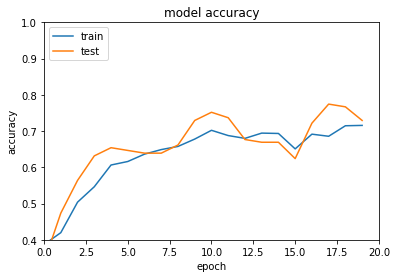

In [13]:
NUM_EPOCHS = 20

history = model.fit(
      train_generator, 
      epochs = NUM_EPOCHS,
      verbose = 1,
      validation_data = validation_generator)

# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.xlim([0,NUM_EPOCHS])
plt.ylim([0.4,1.0])
plt.show()